In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import numpy as np 
from pathlib import Path
import astropy.units as u
import pickle

save_dir = Path("./data_storage/anna_tmp_cross_correlation")
save_dir.mkdir(parents= True, exist_ok=True)

# Coaligning SPICE 706 raster with FSI 174 image (at date average time) 

In [93]:
from slimfunc_correlation_effort import reproject_map_to_reference
from help_funcs import to_submap
from sunpy.map import Map
from sunpy.map import GenericMap
from saffron.utils import utils

old_SPC706_map:GenericMap = Map("./fits_files/SPICE_706_2024-10-17T00:00:50.215.fits")
FSI_map174:GenericMap = Map('./fits_files/FSI_174_2024-10-17T01:40:55.208.fits')

In [94]:
# set the plot_settings (Optional)
from matplotlib import pyplot as plt
from saffron.utils import normit
old_SPC706_map.plot_settings['cmap'] = 'magma'
old_SPC706_map.plot_settings['norm'] = normit(old_SPC706_map.data)
# step 2
cropped_FSI174 = to_submap(FSI_map174, old_SPC706_map, expand=[10,10] * u.arcsec)
# step 3
spice706_on_fsi174:GenericMap = reproject_map_to_reference(cropped_FSI174 , old_SPC706_map)
cy174 = spice706_on_fsi174.meta["CRPIX2"] - 1.0  
cx174 = spice706_on_fsi174.meta["CRPIX1"] - 1.0
center_174 = (cy174, cx174)

# In case smoothing is desired (optional)
if False: #Denoising the reprojected map
  from watroo import denoise, B3spline
  import saffron.utils
  data = spice706_on_fsi174.data.copy()
  data[np.isnan(data)] = 0

  data = denoise(data, scaling_function=B3spline, weights=[20,20,1,1])
  data[np.isnan(spice706_on_fsi174.data)] = np.nan
  if True: #Plotting the denoising results
    fig,axis = plt.subplots(1,3,figsize=(10,5))
    fig.subplots_adjust(top=0.9,right=0.95,left=0.05)
    axis[0].set_title("Original data")
    axis[1].set_title("Denoised data")
    axis[0].pcolormesh(spice706_on_fsi174.data,cmap='magma',norm=normit(spice706_on_fsi174.data))
    axis[1].pcolormesh(data,cmap='magma',norm=normit(data)) 
    axis[2].set_title("Relative difference")
    diff = np.abs(data - spice706_on_fsi174.data)/ np.abs(spice706_on_fsi174.data)
    im = axis[2].pcolormesh(diff,cmap='bwr',norm=normit(diff))
    plt.colorbar(im, ax=axis[2])
    plt.show()

  spice706_on_fsi174 = GenericMap(data, spice706_on_fsi174.meta,plot_settings=spice706_on_fsi174.plot_settings)


In [95]:
print(cropped_FSI174.meta['CDELT1'],cropped_FSI174.meta['CDELT2'])
print(spice706_on_fsi174.meta['CDELT1'],spice706_on_fsi174.meta['CDELT2'])
print(old_SPC706_map.meta['CDELT1']*3600,old_SPC706_map.meta['CDELT2']*3600)

4.44012445 4.44012445
4.44012445 4.44012445
6.00000000000012 1.0979999999999999


In [96]:
from slimfunc_correlation_effort import optimize_alignment_local_grad_disc_persworkers, plot_alignment_before_after, correlation_with_iteration, plot_history_scatter, make_corrected_wcs_map, find_original_correction
# Step 4
if True:
    best_params_706, history_706 = optimize_alignment_local_grad_disc_persworkers(
        cropped_FSI174.data,
        spice706_on_fsi174.data,
        dx0=0.0,  #firt x shift position in pixel space
        dy0=0.0,  #firt y shift position in pixel space
        squeeze_x0= 1.0, #first x scale in pixel space. Warning: scale is a multiplication factor
        squeeze_y0=1.0, #first x scale in pixel space
        
        # per-parameter initial steps (0 means no variation in the given parameter space)
        step_dx0=1.0, # first x shift step size to be used for correction
        step_dy0=1.0, # first y shift step size to be used for correction
        step_sx0=0.05, # first x scale step size to be used for correction
        step_sy0=1e-3, # first x scale step size to be used for correction
        
        # per-parameter minimum steps
        min_step_dy=0.1, # last x shift step size to be used for correction
        min_step_dx=0.1, # last y shift step size to be used for correction
        min_step_sx=1e-3, # last x scale step size to be used for correction
        min_step_sy=1e-3, # last x scale step size to be used for correction
        
        # optimization parameters
        n_neighbors=40, #number of neighbors to check when hill climbing
        max_iter=40, # maximum hill climbs 
        center=center_174, # center location for the squeezing
        squeeze_x_bounds=   (0.5, 2), # boundaries of the climbing area.
        squeeze_y_bounds=   (0.5, 2),
        shift_range     =   (-50, 50),
        n_jobs=40, # CPU jobs adjust accordingly.
        verbose=True, 
        
        # plateau detection in correlation space
        corr_atol=1e-4, # absolute tolerence.
        corr_rtol=1e-3, # relative tolerence
        plateau_iters=4, # check this times to consider peak reached.
        # per-parameter shrink factors on *plateau* (division)
        # if a factor is None -> jump directly to min for that parameter on plateau
        shrink_factor_dx=None,
        shrink_factor_dy=None,
        shrink_factor_sx=None,
        shrink_factor_sy=None,
    )
# Step 5
corrected_spice_706_wcs = make_corrected_wcs_map(spice706_on_fsi174, best_params_706)

# Step 6
new_SPC706_map =  find_original_correction(corrected_spice_706_wcs, spice706_on_fsi174, old_SPC706_map)


Initial: dx=0.000, dy=0.000, sx=1.00000, sy=1.00000, corr=0.340067
[iter 1] best local corr = 0.404824, global best = 0.404824
[iter 1] gradient step accepted: dx=-1.856, dy=-2.136, sx=1.05798, sy=0.99987, corr=0.457882
[iter 2] best local corr = 0.519201, global best = 0.519201
[iter 2] gradient step accepted: dx=-3.688, dy=-4.292, sx=1.12194, sy=0.99974, corr=0.521592
[iter 3] best local corr = 0.568552, global best = 0.568552
[iter 3] fallback to best local (no step shrink).
[iter 4] best local corr = 0.624674, global best = 0.624674
[iter 4] gradient step accepted: dx=-1.711, dy=-6.316, sx=1.11970, sy=0.99975, corr=0.625050
[iter 5] best local corr = 0.690432, global best = 0.690432
[iter 5] gradient step accepted: dx=-0.741, dy=-7.346, sx=1.11562, sy=0.99978, corr=0.691249
[iter 6] best local corr = 0.759484, global best = 0.759484
[iter 6] fallback to best local (no step shrink).
[iter 7] best local corr = 0.821606, global best = 0.821606
[iter 7] fallback to best local (no step 

/tmp/ipykernel_2752234/2771475836.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


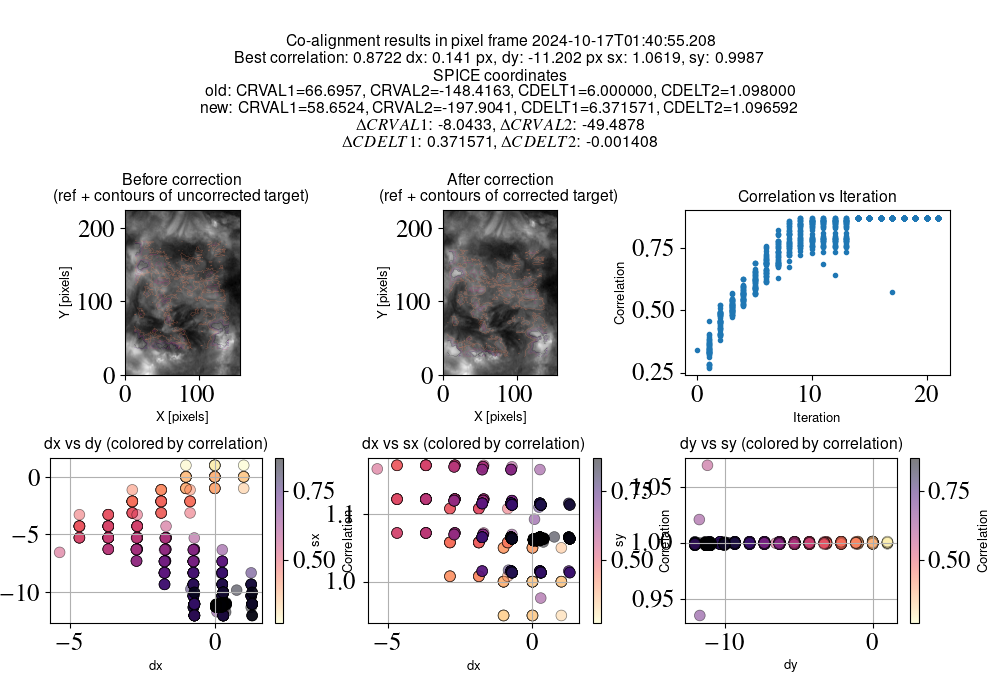

2026-01-20 22:54:23 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2026-01-20 22:54:23 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y data_storage/anna_tmp_cross_correlation/fsi174_spice_corrected_SPICE_view_raster_20241017T014055.208.mp4
2026-01-20 22:54:27 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2026-01-20 22:54:27 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y data_storage/anna_tmp_cross_correlation/fsi174_spice_uncorrected_SPICE_view_raster_20241017T014055.208.mp4


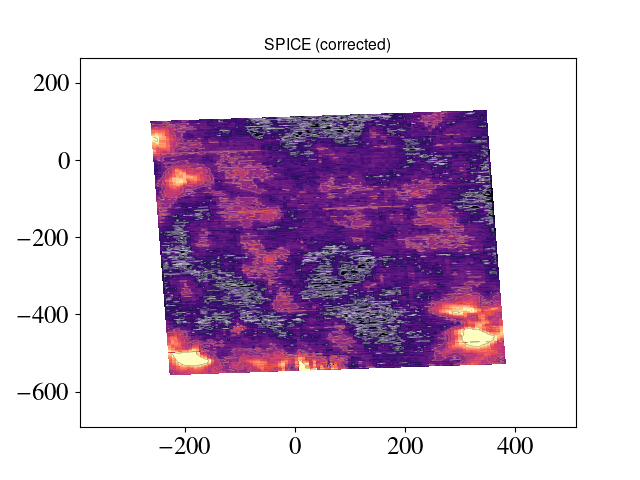

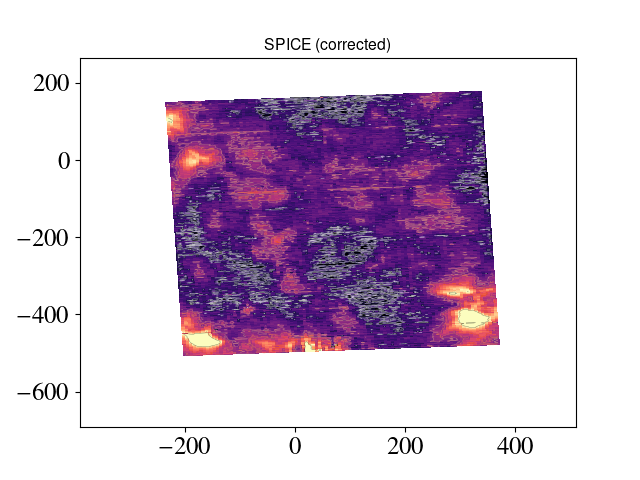

In [97]:
from astropy.units import Quantity
import matplotlib.pyplot as plt
if True: #Plotting the results
    fig,axis = plt.subplots(2,3,figsize=(10,7))
    fig.subplots_adjust(top=0.7,right=0.95,left=0.05,hspace=0.5)
    text = f"Co-alignment results in pixel frame { spice706_on_fsi174.meta['date-obs']}\nBest correlation: {best_params_706['corr']:.4f} dx: {best_params_706['dx']:.3f} px, dy: {best_params_706['dy']:.3f} px sx: {best_params_706['squeeze_x']:.4f}, sy: {best_params_706['squeeze_y']:.4f}\n"
    text+= f"SPICE coordinates\nold: CRVAL1={Quantity(old_SPC706_map.meta['CRVAL1'],old_SPC706_map.meta['CUNIT1']).to('arcsec').value:.4f}, CRVAL2={Quantity(old_SPC706_map.meta['CRVAL2'],old_SPC706_map.meta['CUNIT2']).to('arcsec').value:.4f}, CDELT1={Quantity(old_SPC706_map.meta['CDELT1'],old_SPC706_map.meta['CUNIT1']).to('arcsec').value:.6f}, CDELT2={Quantity(old_SPC706_map.meta['CDELT2'],old_SPC706_map.meta['CUNIT2']).to('arcsec').value:.6f}\n"
    text+=                    f"new: CRVAL1={Quantity(new_SPC706_map.meta['CRVAL1'],new_SPC706_map.meta['CUNIT1']).to('arcsec').value:.4f}, CRVAL2={Quantity(new_SPC706_map.meta['CRVAL2'],new_SPC706_map.meta['CUNIT2']).to('arcsec').value:.4f}, CDELT1={Quantity(new_SPC706_map.meta['CDELT1'],new_SPC706_map.meta['CUNIT1']).to('arcsec').value:.6f}, CDELT2={Quantity(new_SPC706_map.meta['CDELT2'],new_SPC706_map.meta['CUNIT2']).to('arcsec').value:.6f}\n"
    text+= f'$\Delta CRVAL1$: {Quantity(new_SPC706_map.meta["CRVAL1"] - old_SPC706_map.meta["CRVAL1"], new_SPC706_map.meta["CUNIT1"]).to("arcsec").value:.4f}, $\Delta CRVAL2$: {Quantity(new_SPC706_map.meta["CRVAL2"] - old_SPC706_map.meta["CRVAL2"], new_SPC706_map.meta["CUNIT2"]).to("arcsec").value:.4f}\n'
    text+= f'$\Delta CDELT1$: {Quantity(new_SPC706_map.meta["CDELT1"] - old_SPC706_map.meta["CDELT1"], new_SPC706_map.meta["CUNIT1"]).to("arcsec").value:.6f}, $\Delta CDELT2$: {Quantity(new_SPC706_map.meta["CDELT2"] - old_SPC706_map.meta["CDELT2"], new_SPC706_map.meta["CUNIT2"]).to("arcsec").value:.6f}\n'
    # text+= f''
    plt.text(0.5, 0.95, text, ha='center', va='top', transform=fig.transFigure, fontsize=12)
    plot_alignment_before_after(
        cropped_FSI174,
        spice706_on_fsi174,
        best_params_706,
        center= center_174,
        axes=axis[0 , :2]
    )
    correlation_with_iteration(history_706,ax=axis[0,2])
    plot_history_scatter(history_706, "dx", "dy",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,0])
    plot_history_scatter(history_706, "dx", "sx",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,1])
    plot_history_scatter(history_706, "dy", "sy",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,2])
    save_fig = save_dir / f"coalignment_raster_706_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}_figures.png"

    plt.tight_layout()
    plt.savefig(save_fig, dpi=300)
    plt.show()


    if True:
        from sunpy.map import Map

        # plot_coalignment_results(old_SPC706_map, new_line_map, CR_map, raster.AlignmentObject)
        # create my own plotter

        import matplotlib.pyplot as plt
        from matplotlib.animation import FuncAnimation
        from saffron.utils import get_coord_mat
        from slimfunc_correlation_effort import blink_maps
        lonSPICE, latSPICE = get_coord_mat(corrected_spice_706_wcs)
        data = corrected_spice_706_wcs.data

        # xy lim is where the adta is not nan min and max 
        mask = np.isfinite(data)
        x_min = np.nanmin(lonSPICE[mask])
        x_max = np.nanmax(lonSPICE[mask])
        y_min = np.nanmin(latSPICE[mask])
        y_max = np.nanmax(latSPICE[mask])
        diff_x = x_max - x_min
        diff_y = y_max - y_min
        extx = 0.2
        exty = 0.2
        xy_lim = [
        [
            x_min - extx*diff_x, 
            x_max + extx*diff_x
        ],  [
            y_min - exty*diff_y, 
            y_max + exty*diff_y
            ]]

        save_vid_corrected = save_dir / f"fsi174_spice_corrected_SPICE_view_raster_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}.mp4"
        save_vid_uncorrected = save_dir / f"fsi174_spice_uncorrected_SPICE_view_raster_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}.mp4"
        fig, ani, controls = blink_maps(
            cropped_FSI174,new_SPC706_map,
            interval=800,
            n_cycles=10,
            use_widgets=False,
            save_path=save_vid_corrected,
            save_kwargs={"fps": 2, "dpi": 300, "writer": "ffmpeg"},
            xylims=xy_lim,  
        )

        fig, ani, controls = blink_maps(
            cropped_FSI174,old_SPC706_map,
            interval=800,
            n_cycles=10,
            use_widgets=False,
            save_path=save_vid_uncorrected,
            save_kwargs={"fps": 2, "dpi": 300, "writer": "ffmpeg"},
            xylims=xy_lim,  
        )


# Coaling weak SPICE 706 raster with FSI 174 image

In [98]:
old_SPC706_map:GenericMap = Map("./fits_files/SPICE_706_20250918T154730.820.fits")
FSI_map174:GenericMap = Map('./fits_files/FSI_174_20250918T154730.820.fits')
data  = old_SPC706_map.data.copy()
data[:120] = np.nan
data[700:] = np.nan

old_SPC706_map = GenericMap(data, old_SPC706_map.meta,plot_settings=old_SPC706_map.plot_settings)

In [99]:
# set the plot_settings (Optional)
from saffron.utils import normit
old_SPC706_map.plot_settings['cmap'] = 'magma'
old_SPC706_map.plot_settings['norm'] = normit(old_SPC706_map.data)
# step 2
cropped_FSI174 = to_submap(FSI_map174, old_SPC706_map, expand=[300,300] * u.arcsec)
# step 3
spice706_on_fsi174:GenericMap = reproject_map_to_reference(cropped_FSI174 , old_SPC706_map)
cy174 = spice706_on_fsi174.meta["CRPIX2"] - 1.0  
cx174 = spice706_on_fsi174.meta["CRPIX1"] - 1.0
center_174 = (cy174, cx174)

# In case smoothing is desired (optional)
if False: #Denoising the reprojected map
  from watroo import denoise, B3spline
  import saffron.utils
  data = spice706_on_fsi174.data.copy()
  all_nansraws = np.all(np.isnan(data),axis=1)
  all_nanscols = np.all(np.isnan(data),axis=0)
  subdata = data[~all_nansraws,:][:,~all_nanscols].copy() 
  
  subdata[np.isnan(subdata)] = 0

  subdata = denoise(subdata, scaling_function=B3spline, weights=[20,5,1,1])
  data = np.full(spice706_on_fsi174.data.shape, np.nan)
  
  data[np.ix_(~all_nansraws, ~all_nanscols)] = subdata  
  # data[np.isnan(spice706_on_fsi174.data)] = np.nan
  if True: #Plotting the denoising results
    fig,axis = plt.subplots(1,3,figsize=(10,5))
    fig.subplots_adjust(top=0.9,right=0.95,left=0.05)
    axis[0].set_title("Original data")
    axis[1].set_title("Denoised data")
    axis[0].pcolormesh(spice706_on_fsi174.data,cmap='magma',norm=normit(spice706_on_fsi174.data))
    axis[1].pcolormesh(data,cmap='magma',norm=normit(data)) 
    axis[2].set_title("Relative difference")
    diff = np.abs(data - spice706_on_fsi174.data)/ np.abs(spice706_on_fsi174.data)
    im = axis[2].pcolormesh(diff,cmap='bwr',norm=normit(diff))
    plt.colorbar(im, ax=axis[2])
    plt.show()

  spice706_on_fsi174 = GenericMap(data, spice706_on_fsi174.meta,plot_settings=spice706_on_fsi174.plot_settings)


In [100]:
from slimfunc_correlation_effort import optimize_alignment_local_grad_disc_persworkers, plot_alignment_before_after, correlation_with_iteration, plot_history_scatter, make_corrected_wcs_map, find_original_correction
# Step 4
if True:
    best_params_706, history_706 = optimize_alignment_local_grad_disc_persworkers(
        cropped_FSI174.data,
        spice706_on_fsi174.data,
        dx0=0.0,  #firt x shift position in pixel space
        dy0=0.0,  #firt y shift position in pixel space
        squeeze_x0= 1.0, #first x scale in pixel space. Warning: scale is a multiplication factor
        squeeze_y0=1.0, #first x scale in pixel space
        
        # per-parameter initial steps (0 means no variation in the given parameter space)
        step_dx0=1.0, # first x shift step size to be used for correction
        step_dy0=1.0, # first y shift step size to be used for correction
        step_sx0=0.05, # first x scale step size to be used for correction
        step_sy0=1e-3, # first x scale step size to be used for correction
        
        # per-parameter minimum steps
        min_step_dy=0.1, # last x shift step size to be used for correction
        min_step_dx=0.1, # last y shift step size to be used for correction
        min_step_sx=1e-3, # last x scale step size to be used for correction
        min_step_sy=1e-3, # last x scale step size to be used for correction
        
        # optimization parameters
        n_neighbors=40, #number of neighbors to check when hill climbing
        max_iter=40, # maximum hill climbs 
        center=center_174, # center location for the squeezing
        squeeze_x_bounds=   (0.5, 2), # boundaries of the climbing area.
        squeeze_y_bounds=   (0.5, 2),
        shift_range     =   (-100, 100),
        n_jobs=40, # CPU jobs adjust accordingly.
        verbose=True, 
        
        # plateau detection in correlation space
        corr_atol=1e-4, # absolute tolerence.
        corr_rtol=1e-3, # relative tolerence
        plateau_iters=4, # check this times to consider peak reached.
        # per-parameter shrink factors on *plateau* (division)
        # if a factor is None -> jump directly to min for that parameter on plateau
        shrink_factor_dx=None,
        shrink_factor_dy=None,
        shrink_factor_sx=None,
        shrink_factor_sy=None,
    )

    if False and best_params_706['corr'] < 0.75:#to be sure recalculate if the finale correlation is less than 0.7
        #repeat
        # print in red 
        print(f"\033[91mLow correlation {best_params_706['corr']:.4f} for raster {spice706_on_fsi174.meta['date-obs']}, repeating optimization...\033[0m")
        best_params_706, history_706 = optimize_alignment_local_grad_disc_persworkers(
            cropped_FSI.data,
            spice706_on_fsi174.data,
            dx0=0.0,
            dy0=0.0,
            squeeze_x0= 1.0,
            squeeze_y0=1.0,
            # per-parameter initial steps
            step_dx0=2.0,
            step_dy0=2.0,
            step_sx0=0.1,
            step_sy0=0.1,
            # per-parameter minimum steps
            min_step_dy=0.1,
            min_step_dx=0.1,
            min_step_sx=1e-3,
            min_step_sy=1e-3,
            # optimization parameters
            n_neighbors=100,
            max_iter=40,
            center=center,
            squeeze_x_bounds=   (0.5, 2),
            squeeze_y_bounds=   (0.5, 2),
            shift_range     =   (-50, 50),
            n_jobs=40,
            verbose=True,
            # plateau detection in correlation space
            corr_atol=1e-4,
            corr_rtol=1e-3,
            plateau_iters=4,
            # per-parameter shrink factors on *plateau* (division)
            # if a factor is None -> jump directly to min for that parameter on plateau
            shrink_factor_dx=None,
            shrink_factor_dy=None,
            shrink_factor_sx=None,
            shrink_factor_sy=None,
        )
    
# Step 5
corrected_spice_706_wcs = make_corrected_wcs_map(spice706_on_fsi174, best_params_706)

# Step 6
new_SPC706_map =  find_original_correction(corrected_spice_706_wcs, spice706_on_fsi174, old_SPC706_map)


Initial: dx=0.000, dy=0.000, sx=1.00000, sy=1.00000, corr=0.407974
[iter 1] best local corr = 0.410849, global best = 0.410849
[iter 1] fallback to best local (no step shrink).
[iter 2] best local corr = 0.413940, global best = 0.413940
[iter 2] fallback to best local (no step shrink).
[iter 3] best local corr = 0.416648, global best = 0.416648
[iter 3] fallback to best local (no step shrink).
[iter 4] best local corr = 0.418954, global best = 0.418954
[iter 4] fallback to best local (no step shrink).
[iter 5] best local corr = 0.420846, global best = 0.420846
[iter 5] fallback to best local (no step shrink).
[iter 6] best local corr = 0.422314, global best = 0.422314
[iter 6] fallback to best local (no step shrink).
[iter 7] best local corr = 0.423351, global best = 0.423351
[iter 7] fallback to best local (no step shrink).
[iter 8] best local corr = 0.423956, global best = 0.423956
[iter 8] fallback to best local (no step shrink).
[iter 9] best local corr = 0.425666, global best = 0.

/tmp/ipykernel_2752234/2771475836.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


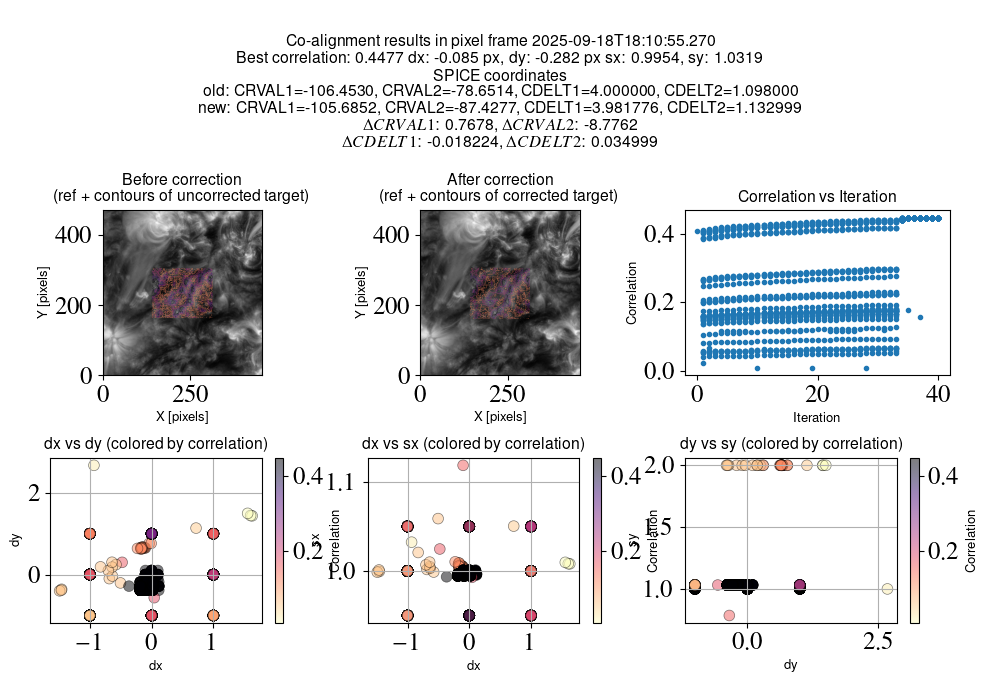

2026-01-20 22:55:36 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2026-01-20 22:55:36 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y data_storage/anna_tmp_cross_correlation/fsi174_spice_corrected_SPICE_view_raster_20250918T181055.270.mp4


2026-01-20 22:55:42 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2026-01-20 22:55:42 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y data_storage/anna_tmp_cross_correlation/fsi174_spice_uncorrected_SPICE_view_raster_20250918T181055.270.mp4


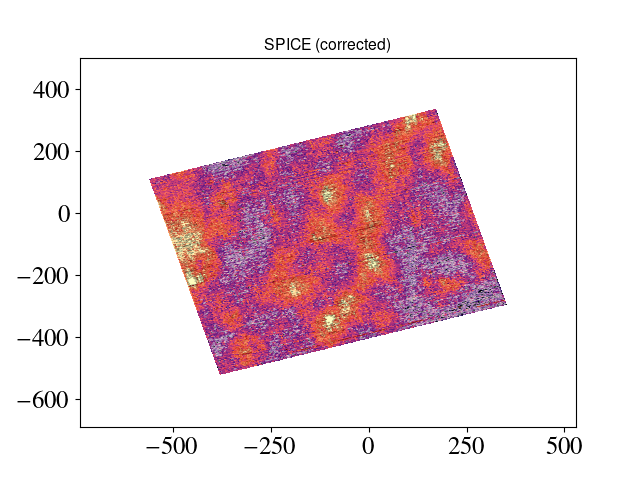

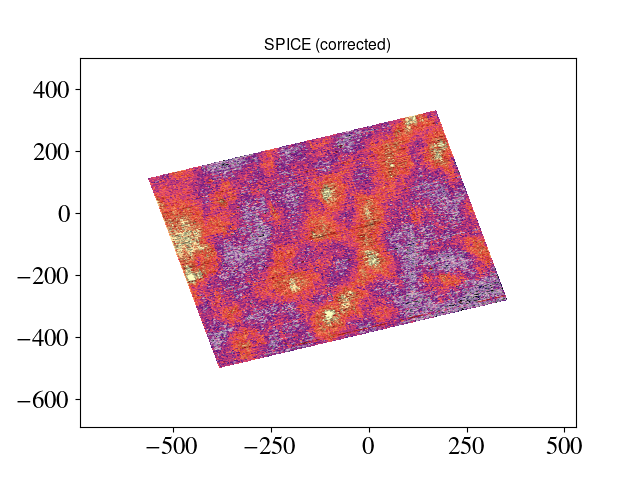

In [101]:
from astropy.units import Quantity
import matplotlib.pyplot as plt
if True: #Plotting the results
    fig,axis = plt.subplots(2,3,figsize=(10,7))
    fig.subplots_adjust(top=0.7,right=0.95,left=0.05,hspace=0.5)
    text = f"Co-alignment results in pixel frame { spice706_on_fsi174.meta['date-obs']}\nBest correlation: {best_params_706['corr']:.4f} dx: {best_params_706['dx']:.3f} px, dy: {best_params_706['dy']:.3f} px sx: {best_params_706['squeeze_x']:.4f}, sy: {best_params_706['squeeze_y']:.4f}\n"
    text+= f"SPICE coordinates\nold: CRVAL1={Quantity(old_SPC706_map.meta['CRVAL1'],old_SPC706_map.meta['CUNIT1']).to('arcsec').value:.4f}, CRVAL2={Quantity(old_SPC706_map.meta['CRVAL2'],old_SPC706_map.meta['CUNIT2']).to('arcsec').value:.4f}, CDELT1={Quantity(old_SPC706_map.meta['CDELT1'],old_SPC706_map.meta['CUNIT1']).to('arcsec').value:.6f}, CDELT2={Quantity(old_SPC706_map.meta['CDELT2'],old_SPC706_map.meta['CUNIT2']).to('arcsec').value:.6f}\n"
    text+=                    f"new: CRVAL1={Quantity(new_SPC706_map.meta['CRVAL1'],new_SPC706_map.meta['CUNIT1']).to('arcsec').value:.4f}, CRVAL2={Quantity(new_SPC706_map.meta['CRVAL2'],new_SPC706_map.meta['CUNIT2']).to('arcsec').value:.4f}, CDELT1={Quantity(new_SPC706_map.meta['CDELT1'],new_SPC706_map.meta['CUNIT1']).to('arcsec').value:.6f}, CDELT2={Quantity(new_SPC706_map.meta['CDELT2'],new_SPC706_map.meta['CUNIT2']).to('arcsec').value:.6f}\n"
    text+= f'$\Delta CRVAL1$: {Quantity(new_SPC706_map.meta["CRVAL1"] - old_SPC706_map.meta["CRVAL1"], new_SPC706_map.meta["CUNIT1"]).to("arcsec").value:.4f}, $\Delta CRVAL2$: {Quantity(new_SPC706_map.meta["CRVAL2"] - old_SPC706_map.meta["CRVAL2"], new_SPC706_map.meta["CUNIT2"]).to("arcsec").value:.4f}\n'
    text+= f'$\Delta CDELT1$: {Quantity(new_SPC706_map.meta["CDELT1"] - old_SPC706_map.meta["CDELT1"], new_SPC706_map.meta["CUNIT1"]).to("arcsec").value:.6f}, $\Delta CDELT2$: {Quantity(new_SPC706_map.meta["CDELT2"] - old_SPC706_map.meta["CDELT2"], new_SPC706_map.meta["CUNIT2"]).to("arcsec").value:.6f}\n'
    # text+= f''
    plt.text(0.5, 0.95, text, ha='center', va='top', transform=fig.transFigure, fontsize=12)
    plot_alignment_before_after(
        cropped_FSI174,
        spice706_on_fsi174,
        best_params_706,
        center= center_174,
        axes=axis[0 , :2]
    )
    correlation_with_iteration(history_706,ax=axis[0,2])
    plot_history_scatter(history_706, "dx", "dy",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,0])
    plot_history_scatter(history_706, "dx", "sx",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,1])
    plot_history_scatter(history_706, "dy", "sy",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,2])
    save_fig = save_dir / f"coalignment_raster_706_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}_figures.png"

    plt.tight_layout()
    plt.savefig(save_fig, dpi=300)
    plt.show()


    if True:
        from sunpy.map import Map

        # plot_coalignment_results(old_SPC706_map, new_line_map, CR_map, raster.AlignmentObject)
        # create my own plotter

        import matplotlib.pyplot as plt
        from matplotlib.animation import FuncAnimation
        from saffron.utils import get_coord_mat
        from slimfunc_correlation_effort import blink_maps
        lonSPICE, latSPICE = get_coord_mat(corrected_spice_706_wcs)
        data = corrected_spice_706_wcs.data

        # xy lim is where the adta is not nan min and max 
        mask = np.isfinite(data)
        x_min = np.nanmin(lonSPICE[mask])
        x_max = np.nanmax(lonSPICE[mask])
        y_min = np.nanmin(latSPICE[mask])
        y_max = np.nanmax(latSPICE[mask])
        diff_x = x_max - x_min
        diff_y = y_max - y_min
        extx = 0.2
        exty = 0.2
        xy_lim = [
        [
            x_min - extx*diff_x, 
            x_max + extx*diff_x
        ],  [
            y_min - exty*diff_y, 
            y_max + exty*diff_y
            ]]

        save_vid_corrected = save_dir / f"fsi174_spice_corrected_SPICE_view_raster_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}.mp4"
        save_vid_uncorrected = save_dir / f"fsi174_spice_uncorrected_SPICE_view_raster_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}.mp4"
        fig, ani, controls = blink_maps(
            cropped_FSI174,new_SPC706_map,
            interval=800,
            n_cycles=10,
            use_widgets=False,
            save_path=save_vid_corrected,
            save_kwargs={"fps": 2, "dpi": 300, "writer": "ffmpeg"},
            xylims=xy_lim,  
        )

        fig, ani, controls = blink_maps(
            cropped_FSI174,old_SPC706_map,
            interval=800,
            n_cycles=10,
            use_widgets=False,
            save_path=save_vid_uncorrected,
            save_kwargs={"fps": 2, "dpi": 300, "writer": "ffmpeg"},
            xylims=xy_lim,  
        )


# Coalign SPICE raster with FSI synthetic raster

## Genrating synthetic raster from FSI 174 image

In [102]:
from help_funcs import (
    build_synthetic_raster_from_maps, 
    get_EUI_paths,
    build_synthetic_raster_from_maps_parallel
    )
# find FSI maps in between the raster time
DATE_BEG = np.datetime64(old_SPC706_map.meta['date-beg'])
DATE_END = np.datetime64(old_SPC706_map.meta['date-end'])
EUI_paths = get_EUI_paths(DATE_BEG - np.timedelta64(10, 'm'), DATE_END + np.timedelta64(10, 'm'))
EUI_paths = sorted(EUI_paths)
EUI_paths = [file_path for file_path in EUI_paths if ('fsi174' in file_path.name.lower()) and ("short" not in file_path.name.lower())]

synthetic_raster_map = build_synthetic_raster_from_maps(
    old_SPC706_map,
    EUI_paths,
    verbose=1,
)
cropped_FSI174 = synthetic_raster_map

[Verbose] Building synthetic raster from FSI maps


2026-01-20 22:55:50 - astropy - WARNING: VerifyWarning: Keyword name 'keycomments' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
2026-01-20 22:55:50 - astropy - WARNING: FITSFixedWarning: CROTA = 16.5820741959 
keyword looks very much like CROTAn but isn't.
2026-01-20 22:55:50 - astropy - WARNING: FITSFixedWarning: The WCS transformation has more axes (3) than the image it is associated with (2)


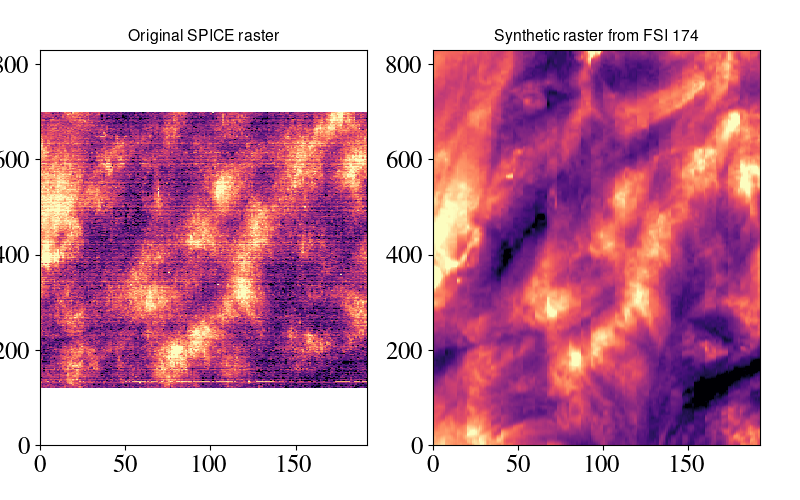

In [103]:
fig,axis = plt.subplots(1,2,figsize=(8,5))
fig.subplots_adjust(top=0.9,right=0.95,left=0.05)
axis[0].set_title("Original SPICE raster")
axis[0].pcolormesh(old_SPC706_map.data,cmap='magma',norm=normit(old_SPC706_map.data))
axis[1].set_title("Synthetic raster from FSI 174")
axis[1].pcolormesh(synthetic_raster_map.data,cmap='magma',norm=normit(synthetic_raster_map.data))
plt.show()

In [104]:
# old_SPC706_map:GenericMap = Map("./fits_files/SPICE_706_20250918T154730.820.fits")
# FSI_map174:GenericMap = Map('./fits_files/FSI_174_20250918T154730.820.fits')
data  = old_SPC706_map.data.copy()
data[:120] = np.nan
data[700:] = np.nan

old_SPC706_map = GenericMap(data, old_SPC706_map.meta,plot_settings=old_SPC706_map.plot_settings)

In [105]:
# set the plot_settings (Optional)
from saffron.utils import normit
old_SPC706_map.plot_settings['cmap'] = 'magma'
old_SPC706_map.plot_settings['norm'] = normit(old_SPC706_map.data)
# step 2
#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------
# cropped_FSI174 = to_submap(FSI_map174, old_SPC706_map, expand=[300,300] * u.arcsec)
cropped_FSI174 = synthetic_raster_map
#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------
# step 3
spice706_on_fsi174:GenericMap = reproject_map_to_reference(cropped_FSI174 , old_SPC706_map)
cy174 = spice706_on_fsi174.meta["CRPIX2"] - 1.0  
cx174 = spice706_on_fsi174.meta["CRPIX1"] - 1.0
center_174 = (cy174, cx174)

# In case smoothing is desired (optional)
if False: #Denoising the reprojected map
  from watroo import denoise, B3spline
  import saffron.utils
  data = spice706_on_fsi174.data.copy()
  all_nansraws = np.all(np.isnan(data),axis=1)
  all_nanscols = np.all(np.isnan(data),axis=0)
  subdata = data[~all_nansraws,:][:,~all_nanscols].copy() 
  
  subdata[np.isnan(subdata)] = 0

  subdata = denoise(subdata, scaling_function=B3spline, weights=[20,20,1,1])
  data = np.full(spice706_on_fsi174.data.shape, np.nan)
  
  data[np.ix_(~all_nansraws, ~all_nanscols)] = subdata  
  # data[np.isnan(spice706_on_fsi174.data)] = np.nan
  if True: #Plotting the denoising results
    fig,axis = plt.subplots(1,3,figsize=(10,5))
    fig.subplots_adjust(top=0.9,right=0.95,left=0.05)
    axis[0].set_title("Original data")
    axis[1].set_title("Denoised data")
    axis[0].pcolormesh(spice706_on_fsi174.data,cmap='magma',norm=normit(spice706_on_fsi174.data))
    axis[1].pcolormesh(data,cmap='magma',norm=normit(data)) 
    axis[2].set_title("Relative difference")
    diff = np.abs(data - spice706_on_fsi174.data)/ np.abs(spice706_on_fsi174.data)
    im = axis[2].pcolormesh(diff,cmap='bwr',norm=normit(diff))
    plt.colorbar(im, ax=axis[2])
    plt.show()

  spice706_on_fsi174 = GenericMap(data, spice706_on_fsi174.meta,plot_settings=spice706_on_fsi174.plot_settings)


In [106]:
from slimfunc_correlation_effort import optimize_alignment_local_grad_disc_persworkers, plot_alignment_before_after, correlation_with_iteration, plot_history_scatter, make_corrected_wcs_map, find_original_correction
# Step 4
if True:
    best_params_706, history_706 = optimize_alignment_local_grad_disc_persworkers(
        cropped_FSI174.data,
        spice706_on_fsi174.data,
        dx0=0.0,  #firt x shift position in pixel space
        dy0=0.0,  #firt y shift position in pixel space
        squeeze_x0= 1.0, #first x scale in pixel space. Warning: scale is a multiplication factor
        squeeze_y0=1.0, #first x scale in pixel space
        
        # per-parameter initial steps (0 means no variation in the given parameter space)
        step_dx0=2.0, # first x shift step size to be used for correction
        step_dy0=2.0, # first y shift step size to be used for correction
        step_sx0=1e-3, # first x scale step size to be used for correction
        step_sy0=1e-3, # first x scale step size to be used for correction
        
        # per-parameter minimum steps
        min_step_dy=0.1, # last x shift step size to be used for correction
        min_step_dx=0.1, # last y shift step size to be used for correction
        min_step_sx=1e-3, # last x scale step size to be used for correction
        min_step_sy=1e-3, # last x scale step size to be used for correction
        
        # optimization parameters
        n_neighbors=40, #number of neighbors to check when hill climbing
        max_iter=40, # maximum hill climbs 
        center=center_174, # center location for the squeezing
        squeeze_x_bounds=   (0.5, 2), # boundaries of the climbing area.
        squeeze_y_bounds=   (0.5, 2),
        shift_range     =   (-100, 100),
        n_jobs=40, # CPU jobs adjust accordingly.
        verbose=True, 
        
        # plateau detection in correlation space
        corr_atol=1e-4, # absolute tolerence.
        corr_rtol=1e-3, # relative tolerence
        plateau_iters=4, # check this times to consider peak reached.
        # per-parameter shrink factors on *plateau* (division)
        # if a factor is None -> jump directly to min for that parameter on plateau
        shrink_factor_dx=None,
        shrink_factor_dy=None,
        shrink_factor_sx=None,
        shrink_factor_sy=None,
    )
    
# Step 5
corrected_spice_706_wcs = make_corrected_wcs_map(spice706_on_fsi174, best_params_706)

# Step 6
new_SPC706_map =  find_original_correction(corrected_spice_706_wcs, spice706_on_fsi174, old_SPC706_map)


Initial: dx=0.000, dy=0.000, sx=1.00000, sy=1.00000, corr=0.601652
[iter 1] best local corr = 0.632999, global best = 0.632999
[iter 1] fallback to best local (no step shrink).
[iter 2] best local corr = 0.649091, global best = 0.649091
[iter 2] fallback to best local (no step shrink).
[iter 3] best local corr = 0.662026, global best = 0.662026
[iter 3] fallback to best local (no step shrink).
[iter 4] best local corr = 0.673783, global best = 0.673783
[iter 4] gradient step accepted: dx=0.012, dy=-6.828, sx=0.99661, sy=0.99800, corr=0.678770
[iter 5] best local corr = 0.688579, global best = 0.688579
[iter 5] gradient step accepted: dx=0.037, dy=-9.657, sx=0.99523, sy=0.99800, corr=0.692583
[iter 6] best local corr = 0.699901, global best = 0.699901
[iter 6] gradient step accepted: dx=0.075, dy=-12.485, sx=0.99384, sy=0.99800, corr=0.700552
[iter 7] best local corr = 0.705538, global best = 0.705538
[iter 7] gradient step accepted: dx=0.124, dy=-15.313, sx=0.99245, sy=0.99800, corr=0.

/tmp/ipykernel_2752234/2480189782.py:28: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


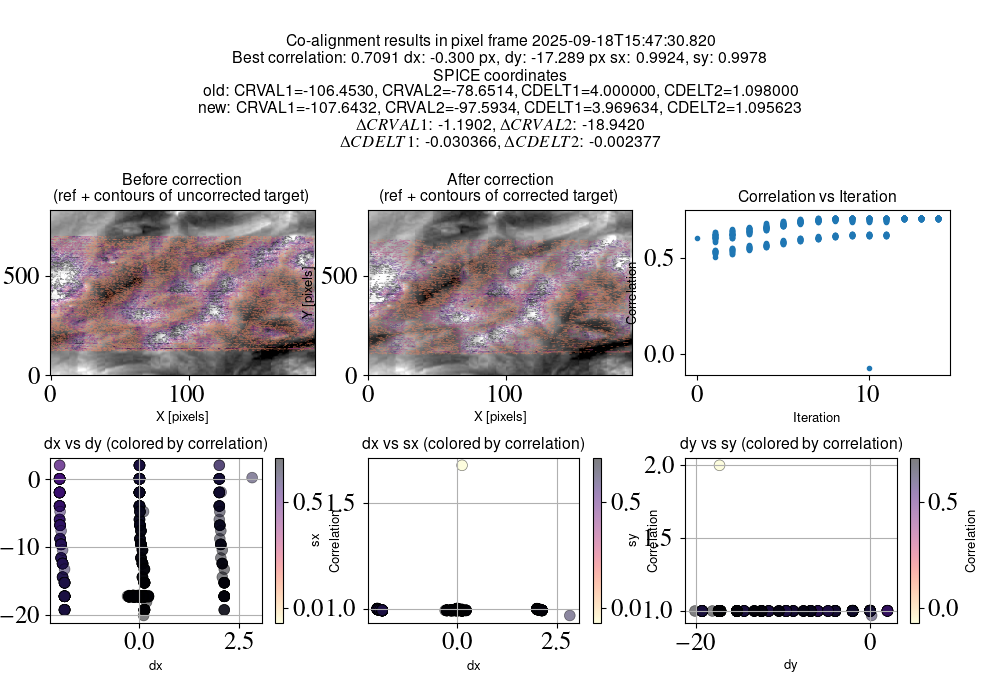

2026-01-20 23:09:03 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2026-01-20 23:09:03 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y data_storage/anna_tmp_cross_correlation/fsi174_synth_spice_corrected_SPICE_view_raster_20250918T154730.820.mp4
2026-01-20 23:09:09 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2026-01-20 23:09:09 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y data_storage/anna_tmp_cross_correlation/fsi174_synth_spice_uncorrected_SPICE_view_raster_20250918T154730.820.mp4


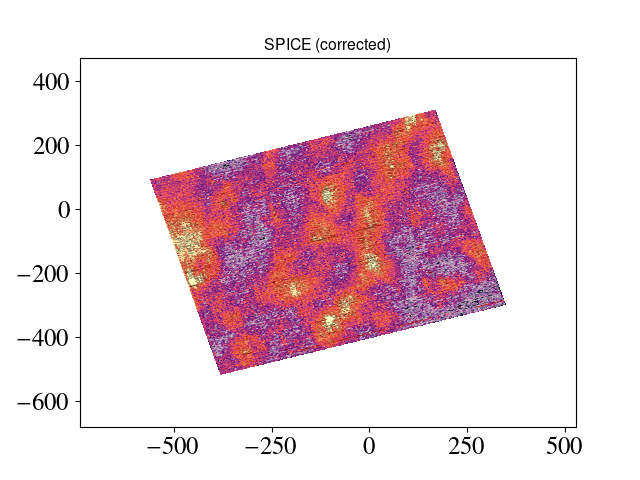

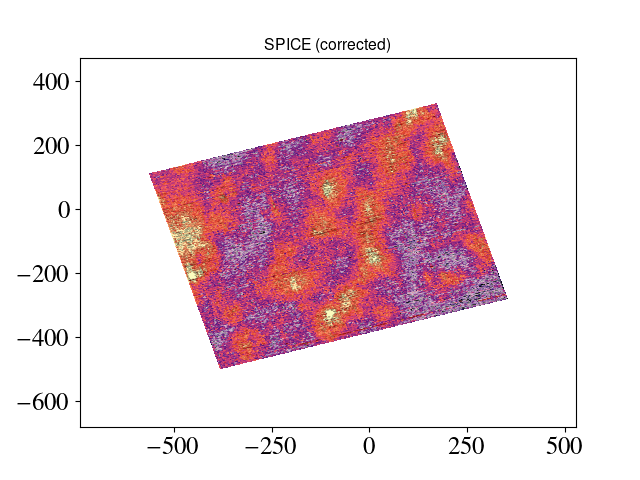

In [107]:
from astropy.units import Quantity
import matplotlib.pyplot as plt
if True: #Plotting the results
    fig,axis = plt.subplots(2,3,figsize=(10,7))
    fig.subplots_adjust(top=0.7,right=0.95,left=0.05,hspace=0.5)
    text = f"Co-alignment results in pixel frame { spice706_on_fsi174.meta['date-obs']}\nBest correlation: {best_params_706['corr']:.4f} dx: {best_params_706['dx']:.3f} px, dy: {best_params_706['dy']:.3f} px sx: {best_params_706['squeeze_x']:.4f}, sy: {best_params_706['squeeze_y']:.4f}\n"
    text+= f"SPICE coordinates\nold: CRVAL1={Quantity(old_SPC706_map.meta['CRVAL1'],old_SPC706_map.meta['CUNIT1']).to('arcsec').value:.4f}, CRVAL2={Quantity(old_SPC706_map.meta['CRVAL2'],old_SPC706_map.meta['CUNIT2']).to('arcsec').value:.4f}, CDELT1={Quantity(old_SPC706_map.meta['CDELT1'],old_SPC706_map.meta['CUNIT1']).to('arcsec').value:.6f}, CDELT2={Quantity(old_SPC706_map.meta['CDELT2'],old_SPC706_map.meta['CUNIT2']).to('arcsec').value:.6f}\n"
    text+=                    f"new: CRVAL1={Quantity(new_SPC706_map.meta['CRVAL1'],new_SPC706_map.meta['CUNIT1']).to('arcsec').value:.4f}, CRVAL2={Quantity(new_SPC706_map.meta['CRVAL2'],new_SPC706_map.meta['CUNIT2']).to('arcsec').value:.4f}, CDELT1={Quantity(new_SPC706_map.meta['CDELT1'],new_SPC706_map.meta['CUNIT1']).to('arcsec').value:.6f}, CDELT2={Quantity(new_SPC706_map.meta['CDELT2'],new_SPC706_map.meta['CUNIT2']).to('arcsec').value:.6f}\n"
    text+= f'$\Delta CRVAL1$: {Quantity(new_SPC706_map.meta["CRVAL1"] - old_SPC706_map.meta["CRVAL1"], new_SPC706_map.meta["CUNIT1"]).to("arcsec").value:.4f}, $\Delta CRVAL2$: {Quantity(new_SPC706_map.meta["CRVAL2"] - old_SPC706_map.meta["CRVAL2"], new_SPC706_map.meta["CUNIT2"]).to("arcsec").value:.4f}\n'
    text+= f'$\Delta CDELT1$: {Quantity(new_SPC706_map.meta["CDELT1"] - old_SPC706_map.meta["CDELT1"], new_SPC706_map.meta["CUNIT1"]).to("arcsec").value:.6f}, $\Delta CDELT2$: {Quantity(new_SPC706_map.meta["CDELT2"] - old_SPC706_map.meta["CDELT2"], new_SPC706_map.meta["CUNIT2"]).to("arcsec").value:.6f}\n'
    # text+= f''
    plt.text(0.5, 0.95, text, ha='center', va='top', transform=fig.transFigure, fontsize=12)
    plot_alignment_before_after(
        cropped_FSI174,
        spice706_on_fsi174,
        best_params_706,
        center= center_174,
        axes=axis[0 , :2]
    )
    correlation_with_iteration(history_706,ax=axis[0,2])
    plot_history_scatter(history_706, "dx", "dy",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,0])
    plot_history_scatter(history_706, "dx", "sx",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,1])
    plot_history_scatter(history_706, "dy", "sy",plot_kwargs= {"cmap":"magma_r", "s":60, "edgecolors":"black",'alpha':0.5, "linewidths":0.5}, ax=axis[1,2])
    for axis in axis.flatten():
        axis.set_aspect('auto')
    save_fig = save_dir / f"coalignment_raster_706_synth{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}_figures.png"

    plt.tight_layout()
    plt.savefig(save_fig, dpi=300)
    plt.show()


    if True:
        from sunpy.map import Map

        # plot_coalignment_results(old_SPC706_map, new_line_map, CR_map, raster.AlignmentObject)
        # create my own plotter

        import matplotlib.pyplot as plt
        from matplotlib.animation import FuncAnimation
        from saffron.utils import get_coord_mat
        from slimfunc_correlation_effort import blink_maps
        lonSPICE, latSPICE = get_coord_mat(corrected_spice_706_wcs)
        data = corrected_spice_706_wcs.data

        # xy lim is where the adta is not nan min and max 
        mask = np.isfinite(data)
        x_min = np.nanmin(lonSPICE[mask])
        x_max = np.nanmax(lonSPICE[mask])
        y_min = np.nanmin(latSPICE[mask])
        y_max = np.nanmax(latSPICE[mask])
        diff_x = x_max - x_min
        diff_y = y_max - y_min
        extx = 0.2
        exty = 0.2
        xy_lim = [
        [
            x_min - extx*diff_x, 
            x_max + extx*diff_x
        ],  [
            y_min - exty*diff_y, 
            y_max + exty*diff_y
            ]]

        save_vid_corrected = save_dir / f"fsi174_synth_spice_corrected_SPICE_view_raster_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}.mp4"
        save_vid_uncorrected = save_dir / f"fsi174_synth_spice_uncorrected_SPICE_view_raster_{ spice706_on_fsi174.meta['date-obs'].replace(':', '').replace('-', '')}.mp4"
        fig, ani, controls = blink_maps(
            cropped_FSI174,new_SPC706_map,
            interval=800,
            n_cycles=10,
            use_widgets=False,
            save_path=save_vid_corrected,
            save_kwargs={"fps": 2, "dpi": 300, "writer": "ffmpeg"},
            xylims=xy_lim,  
        )

        fig, ani, controls = blink_maps(
            cropped_FSI174,old_SPC706_map,
            interval=800,
            n_cycles=10,
            use_widgets=False,
            save_path=save_vid_uncorrected,
            save_kwargs={"fps": 2, "dpi": 300, "writer": "ffmpeg"},
            xylims=xy_lim,  
        )


2026-01-20 20:25:16 - astropy - WARNING: UnitsWarning: 'W/m2/sr/nm' contains multiple slashes, which is discouraged by the FITS standard
2026-01-20 20:25:16 - astropy - WARNING: UnitsWarning: 'W/m2/sr/nm' contains multiple slashes, which is discouraged by the FITS standard


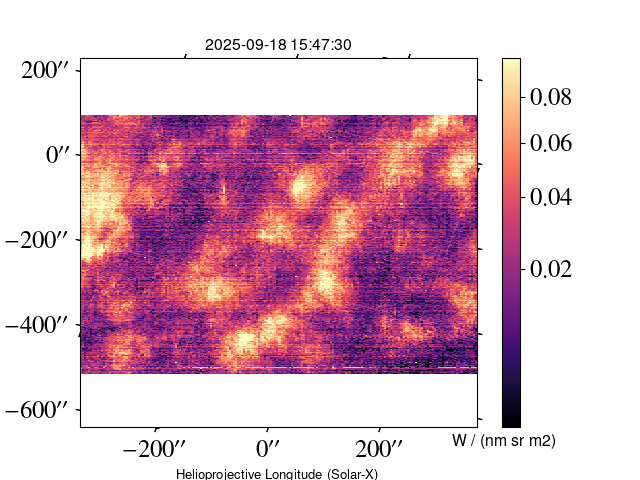

In [88]:
new_SPC706_map.peek(aspect="auto")